This Notebook is to run do exploratory data analysis on our dataset. 

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# --- PART 1: LOAD AND COMBINE ---
root_dir = './Phase2' 
all_dfs = []
exclude_authors = {"Kevin", "Parnika","Agni", "Alfred" ,"instance_clips"} #data mislabeled 

if os.path.exists(root_dir):
    for root, dirs, files in os.walk(root_dir):
        # The folder name is the last part of the 'root' path
        folder_name = os.path.basename(root)

        if folder_name in exclude_authors:
            continue
        
        for file in files:
            if file.endswith(".csv"):
                file_path = os.path.join(root, file)
                temp_df = pd.read_csv(file_path)
                
                # Create the 'author' column from the folder name
                temp_df['author'] = folder_name
                temp_df['source_file'] = file 
                
                # Move 'author' to the first column position
                cols = ['author'] + [c for c in temp_df.columns if c != 'author']
                temp_df = temp_df[cols]
                
                all_dfs.append(temp_df)
    
    if all_dfs:
        data = pd.concat(all_dfs, ignore_index=True)
        print(f"Successfully combined {len(all_dfs)} files.")
    else:
        print("No CSV files found.")
else:
    print("Phase2 directory not found.")

# --- PART 2: THE "BULLETPROOF" CLEANING ---
# Note: Since we added 'author' and 'source_file', the label column 
# position might have shifted. Let's find it by name or original position.
# If your label was the last column of the CSV, it's now the 2nd to last.
label_col = data.columns[-2] 

# FIX: Remove spaces and make lowercase
data[label_col] = data[label_col].astype(str).str.strip().str.lower()

# Detect a REAL change (Label changes OR File changes OR Author changes)
data['change'] = (data[label_col] != data[label_col].shift()) | \
                 (data['source_file'] != data['source_file'].shift())

data['instance_id'] = data['change'].cumsum()

# Group to find durations - we keep author in the aggregate
instance_df = data.groupby('instance_id').agg(
    label=(label_col, 'first'),
    duration=(label_col, 'count'),
    author=('author', 'first'),
    file=('source_file', 'first')
)

# Filter out 'idle' and 'none'
exclude = ['idle', 'none', 'nan']
filtered_instances = instance_df[~instance_df['label'].isin(exclude)]



Successfully combined 11 files.


Phase 2's EDA


/var/folders/hn/dcy0l7cn53v54k9nvcx14kl80000gn/T/ipykernel_50429/1652196564.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = plt.cm.get_cmap('tab20', len(unique_authors))


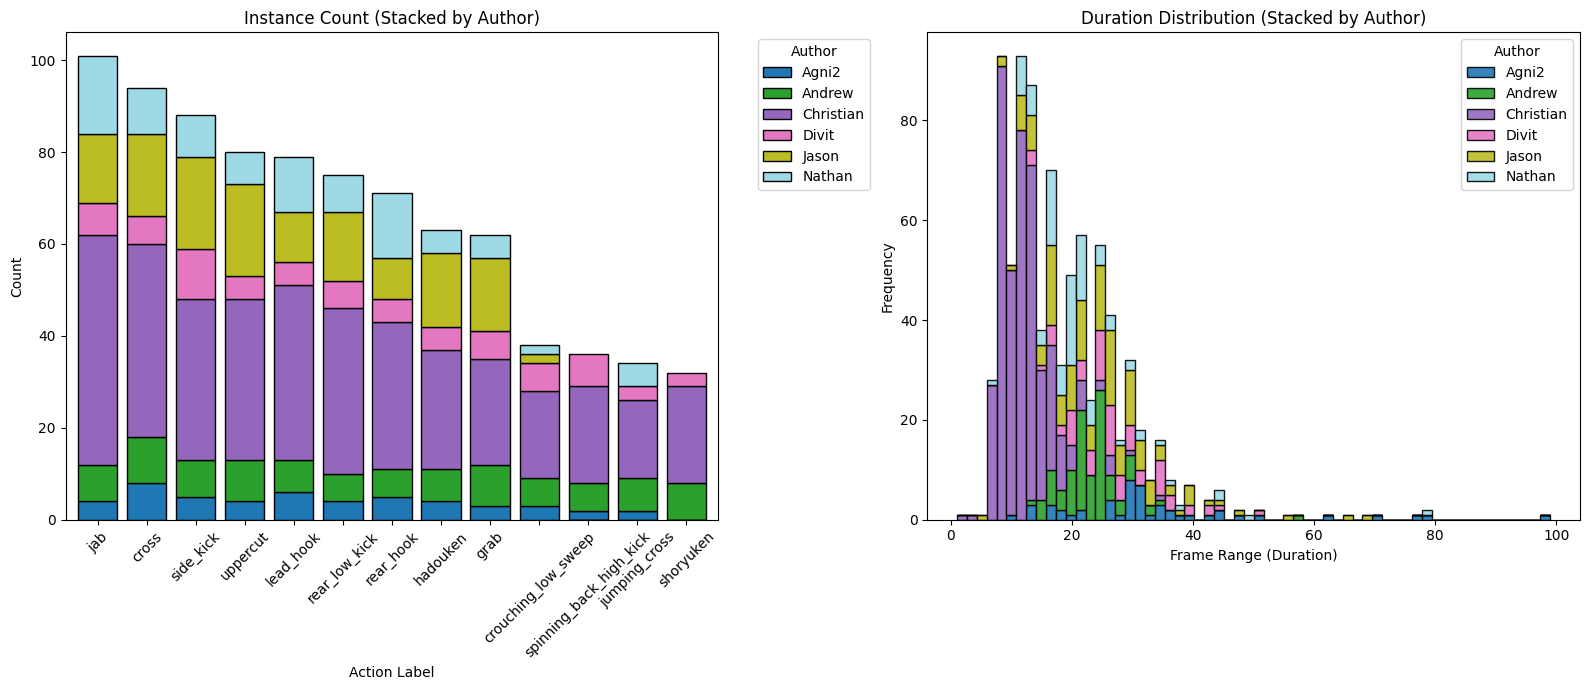

In [13]:


# Ensure data exists before plotting
if 'filtered_instances' in locals() and not filtered_instances.empty:
    
    # 1. SETUP CONSISTENT COLORS
    # Get sorted list of authors so the order is fixed and matches the DataFrame columns
    unique_authors = sorted(filtered_instances['author'].unique())
    
    # Generate a color palette
    # Note: If you have >20 authors, tab20 will reuse colors.
    colormap = plt.cm.get_cmap('tab20', len(unique_authors))
    color_list = [colormap(i) for i in range(len(unique_authors))]
    
    # Create a dictionary to map Author -> Color (for Plot 2 consistency)
    author_color_map = dict(zip(unique_authors, color_list))

    # Initialize Figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

    # --- Plot A: Stacked Bar Chart (Action vs Author) ---
    # We pivot the data: Rows=Actions, Cols=Authors, Values=Count
    pivot_df = pd.crosstab(filtered_instances['label'], filtered_instances['author'])
    
    # --- NEW: SORTING STEP ---
    # Calculate row sums and sort the DataFrame index (Actions) by Total Count descending
    pivot_df = pivot_df.loc[pivot_df.sum(axis=1).sort_values(ascending=False).index]
    
    # Plot using pandas built-in plotting
    pivot_df.plot(kind='bar', stacked=True, ax=ax1, color=color_list, edgecolor='black', width=0.8)
    
    ax1.set_title('Instance Count (Stacked by Author)')
    ax1.set_ylabel('Count')
    ax1.set_xlabel('Action Label')
    ax1.legend(title='Author', bbox_to_anchor=(1.05, 1), loc='upper left') 
    ax1.tick_params(axis='x', rotation=45)

    # --- Plot B: Stacked Histogram (Duration vs Author) ---
    # Prepare data for matplotlib hist
    stacked_data = []
    stacked_colors = []
    stacked_labels = []

    for author in unique_authors:
        durs = filtered_instances[filtered_instances['author'] == author]['duration']
        
        # Only add if this author has data
        if len(durs) > 0:
            stacked_data.append(durs)
            stacked_colors.append(author_color_map[author])
            stacked_labels.append(author)

    ax2.hist(stacked_data, bins=60, stacked=True, 
             color=stacked_colors, label=stacked_labels, 
             edgecolor='black', alpha=0.9)


    ax2.set_title('Duration Distribution (Stacked by Author)')
    ax2.set_xlabel('Frame Range (Duration)')
    ax2.set_ylabel('Frequency')
    ax2.legend(title="Author", loc='upper right')

    plt.tight_layout()
    plt.show()

else:
    print("No data available to plot. Please run Chunk 1 first.")

Per File: Instance statistics EDA

In [18]:
import os
import pandas as pd

# Define your directories
train_dir = "Train_Test_Data/Not_Seperated/Clips_Split_80_20/Train_clips"
test_dir = "Train_Test_Data/Not_Seperated/Clips_Split_80_20/Test_clips"

data_records = []

# Helper function to parse filenames
def parse_directory(directory, split_name):
    if os.path.exists(directory):
        for file in os.listdir(directory):
            if file.endswith(".csv"):
                # Remove '.csv' and split from the right
                name_without_ext = file[:-4]
                parts = name_without_ext.rsplit('_', 2)
                
                # Ensure it perfectly matches action_author_count
                if len(parts) == 3:
                    action, author, _ = parts
                    data_records.append({
                        'action': action, 
                        'author': author, 
                        'split': split_name
                    })

# Parse both directories
parse_directory(train_dir, 'Train')
parse_directory(test_dir, 'Test')

# Create DataFrame
split_df = pd.DataFrame(data_records)

if not split_df.empty:
    print(f"Successfully loaded {len(split_df[split_df['split'] == 'Train'])} Train clips.")
    print(f"Successfully loaded {len(split_df[split_df['split'] == 'Test'])} Test clips.")
else:
    print("No clips found. Check your directory paths.")

Successfully loaded 682 Train clips.
Successfully loaded 171 Test clips.


/var/folders/hn/dcy0l7cn53v54k9nvcx14kl80000gn/T/ipykernel_69750/3923404918.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = plt.cm.get_cmap('tab20', len(unique_authors))


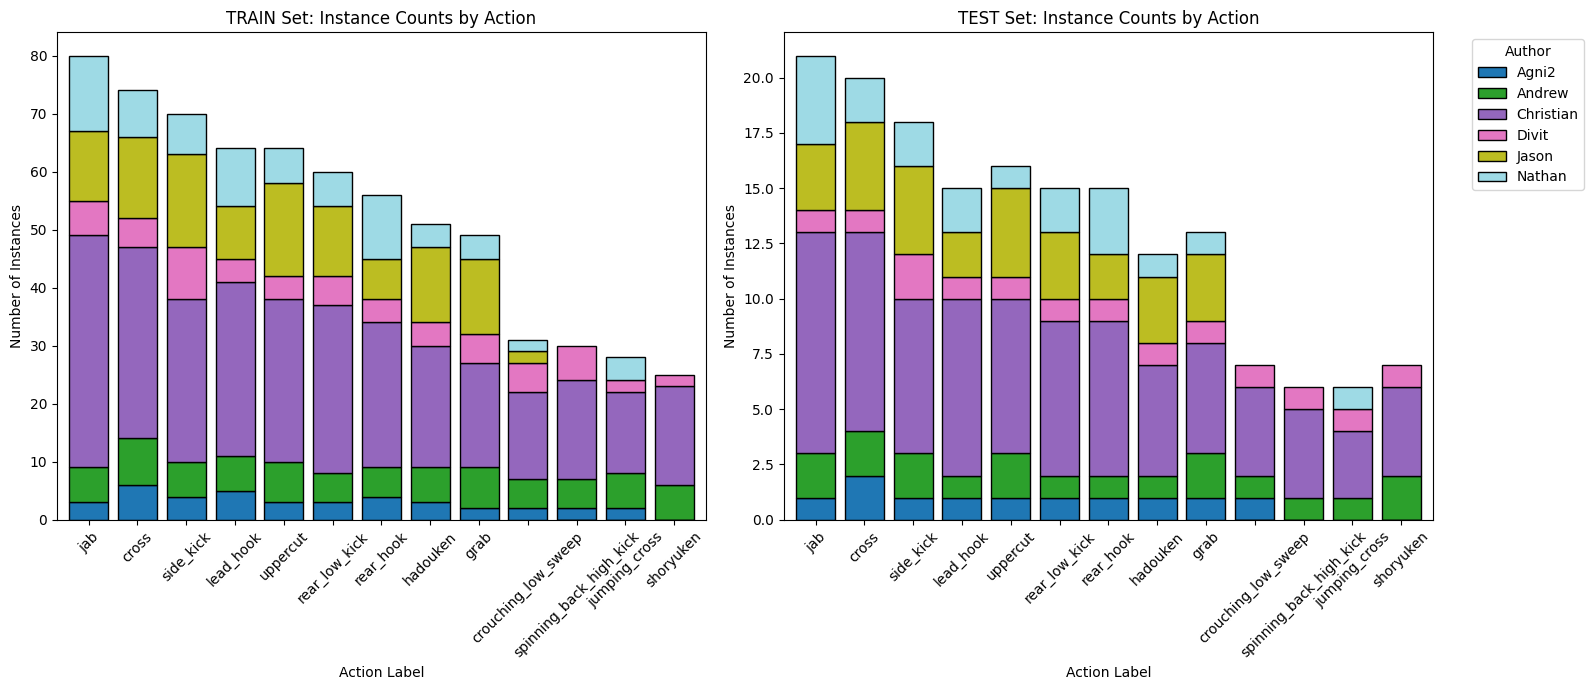

In [19]:
import matplotlib.pyplot as plt

# 1. Filter out 'idle' actions
df_filtered = split_df[split_df['action'] != 'idle'].copy()

if not df_filtered.empty:
    
    # 2. Setup consistent colors across both plots
    unique_authors = sorted(df_filtered['author'].unique())
    colormap = plt.cm.get_cmap('tab20', len(unique_authors))
    color_list = [colormap(i) for i in range(len(unique_authors))]

    # Initialize a 1x2 Figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

    # --- Plot 1: TRAIN SET ---
    train_df = df_filtered[df_filtered['split'] == 'Train']
    pivot_train = pd.crosstab(train_df['action'], train_df['author'])
    
    # Force all authors to be columns to keep colors aligned perfectly
    pivot_train = pivot_train.reindex(columns=unique_authors, fill_value=0)
    
    # Sort actions by total frequency descending
    pivot_train = pivot_train.loc[pivot_train.sum(axis=1).sort_values(ascending=False).index]
    
    pivot_train.plot(kind='bar', stacked=True, ax=ax1, color=color_list, edgecolor='black', width=0.8)
    ax1.set_title('TRAIN Set: Instance Counts by Action')
    ax1.set_ylabel('Number of Instances')
    ax1.set_xlabel('Action Label')
    ax1.tick_params(axis='x', rotation=45)
    ax1.legend().remove() # Remove legend here to prevent double-clutter

    # --- Plot 2: TEST SET ---
    test_df = df_filtered[df_filtered['split'] == 'Test']
    if not test_df.empty:
        pivot_test = pd.crosstab(test_df['action'], test_df['author'])
        
        # Force all authors to be columns to keep colors aligned
        pivot_test = pivot_test.reindex(columns=unique_authors, fill_value=0)
        
        # Sort Test data using the EXACT same action order as Train for an easy 1:1 comparison
        ordered_actions = [idx for idx in pivot_train.index if idx in pivot_test.index]
        missing_in_train = [idx for idx in pivot_test.index if idx not in pivot_train.index] 
        pivot_test = pivot_test.loc[ordered_actions + missing_in_train]

        pivot_test.plot(kind='bar', stacked=True, ax=ax2, color=color_list, edgecolor='black', width=0.8)
        ax2.set_title('TEST Set: Instance Counts by Action')
        ax2.set_ylabel('Number of Instances')
        ax2.set_xlabel('Action Label')
        ax2.tick_params(axis='x', rotation=45)
        
        # Put the master legend on the far right
        ax2.legend(title='Author', bbox_to_anchor=(1.05, 1), loc='upper left') 
    else:
        ax2.set_title('TEST Set: No Data')

    plt.tight_layout()
    plt.show()

else:
    print("No non-idle data available to plot.")